In [22]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torchvision
from torchvision.utils import make_grid

import os
from os.path import join, dirname, exists
import pickle

##Learning framework

You should know how to write this by now:
*    Train procedure
*    Validation procedure

In [14]:
quiet = False

def train(model, train_loader, optimizer, epoch, grad_clip=None):
  model.train()
  
  train_losses = []
  for x in train_loader:
    x = x.cuda().contiguous()
    loss = model.loss(x)
    optimizer.zero_grad()
    loss.backward()
    if grad_clip:
      torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    optimizer.step()
    train_losses.append(loss.item())
  return train_losses

def eval_loss(model, data_loader):
  model.eval()
  total_loss = 0
  with torch.no_grad():
    for x in data_loader:
      x = x.cuda().contiguous()
      loss = model.loss(x)
      total_loss += loss * x.shape[0]
    avg_loss = total_loss / len(data_loader.dataset)

  return avg_loss.item()


def train_epochs(model, train_loader, test_loader, train_args):
  epochs, lr = train_args['epochs'], train_args['lr']
  grad_clip = train_args.get('grad_clip', None)
  optimizer = optim.Adam(model.parameters(), lr=lr)

  train_losses = []
  test_losses = [eval_loss(model, test_loader)]
  for epoch in range(epochs):
    model.train()
    train_losses.extend(train(model, train_loader, optimizer, epoch, grad_clip))
    test_loss = eval_loss(model, test_loader)
    test_losses.append(test_loss)
    if not quiet:
      print(f'Epoch {epoch}, Test loss {test_loss:.4f}')

  return train_losses, test_losses


##Validation

In [3]:
def save_training_plot(train_losses, test_losses, title, fname=None):
    plt.figure()
    n_epochs = len(test_losses) - 1
    x_train = np.linspace(0, n_epochs, len(train_losses))
    x_test = np.arange(n_epochs + 1)

    plt.plot(x_train, train_losses, label='train loss')
    plt.plot(x_test, test_losses, label='test loss')
    plt.legend()
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('NLL')
    if fname is not None:
        savefig(fname)
    else:
        plt.show()

In [4]:
def show_samples(samples, fname=None, nrow=10, title='Samples'):
    samples = (torch.FloatTensor(samples) / 255).permute(0, 3, 1, 2)
    grid_img = make_grid(samples, nrow=nrow)
    plt.figure()
    plt.title(title)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')

    if fname is not None:
        savefig(fname)
    else:
        plt.show()

##MNIST

Add Google Colab access to your Google Drive. Then copy the directory path to your data

In [5]:
def get_data_dir():
    return join('/content', 'drive', 'MyDrive', 'Thèse', 'lesson5')


Let's take a look at the data

In [6]:
def load_pickled_data(fname, include_labels=False):
    with open(fname, 'rb') as f:
        data = pickle.load(f)

    train_data, test_data = data['train'], data['test']
    if 'mnist.pkl' in fname or 'shapes.pkl' in fname:
        # Binarize MNIST and shapes dataset
        train_data = (train_data > 127.5).astype('uint8')
        test_data = (test_data > 127.5).astype('uint8')
    if 'celeb.pkl' in fname:
        train_data = train_data[:, :, :, [2, 1, 0]]
        test_data = test_data[:, :, :, [2, 1, 0]]
    if include_labels:
        return train_data, test_data, data['train_labels'], data['test_labels']
    return train_data, test_data

In [7]:
def visualize_data(dset_type):
    data_dir = get_data_dir()
    if dset_type == 'Shape':
        train_data, test_data = load_pickled_data(join(data_dir, 'shapes.pkl'))
        name = 'Shape'
    elif dset_type == 'MNIST':
        train_data, test_data = load_pickled_data(join(data_dir, 'mnist.pkl'))
        name = 'MNIST'
    else:
        raise Exception('Invalid dset type:', dset_type)

    idxs = np.random.choice(len(train_data), replace=False, size=(100,))
    images = train_data[idxs] * 255
    show_samples(images, title=f'{name} Samples')

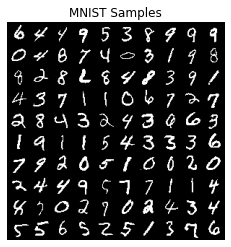

In [8]:
visualize_data('MNIST')

##[MADE](https://arxiv.org/abs/1502.03509)

In [9]:
def to_one_hot(labels, d):
  one_hot = torch.FloatTensor(labels.shape[0], d).cuda()
  one_hot.zero_()
  one_hot.scatter_(1, labels.unsqueeze(1), 1)
  return one_hot

# Code based one Andrej Karpathy's implementation: https://github.com/karpathy/pytorch-made
class MaskedLinear(nn.Linear):
  def __init__(self, in_features, out_features, bias=True):
    super().__init__(in_features, out_features, bias)
    self.register_buffer('mask', torch.ones(out_features, in_features))

  def set_mask(self, mask):
    self.mask.data.copy_(torch.from_numpy(mask.astype(np.uint8).T))

  def forward(self, input):
    return F.linear(input, self.mask * self.weight, self.bias)

class MADE(nn.Module):
  def __init__(self, input_shape, d, hidden_size=[512, 512, 512], 
               ordering=None, one_hot_input=False):
    super().__init__()
    self.input_shape = input_shape
    self.nin = np.prod(input_shape)
    self.nout = self.nin * d
    self.d = d
    self.hidden_sizes = hidden_size
    self.ordering = np.arange(self.nin) if ordering is None else ordering
    self.one_hot_input = one_hot_input

    # define a simple MLP neural net
    self.net = []
    hs = [self.nin * d if one_hot_input else self.nin] + self.hidden_sizes + [self.nout]
    for h0, h1 in zip(hs, hs[1:]):
      self.net.extend([
        MaskedLinear(h0, h1),
        nn.ReLU(),
      ])
    self.net.pop()  # pop the last ReLU for the output layer
    self.net = nn.Sequential(*self.net)

    self.m = {}
    self.create_mask()  # builds the initial self.m connectivity

  def create_mask(self):
    L = len(self.hidden_sizes)

    # sample the order of the inputs and the connectivity of all neurons
    self.m[-1] = self.ordering
    for l in range(L):
      self.m[l] = np.random.randint(self.m[l - 1].min(), 
                                      self.nin - 1, size=self.hidden_sizes[l])

    # construct the mask matrices
    masks = [self.m[l - 1][:, None] <= self.m[l][None, :] for l in range(L)]
    masks.append(self.m[L - 1][:, None] < self.m[-1][None, :])

    masks[-1] = np.repeat(masks[-1], self.d, axis=1)
    if self.one_hot_input:
      masks[0] = np.repeat(masks[0], self.d, axis=0)

    # set the masks in all MaskedLinear layers
    layers = [l for l in self.net.modules() if isinstance(l, MaskedLinear)]
    for l, m in zip(layers, masks):
      l.set_mask(m)

  def forward(self, x):
    batch_size = x.shape[0]
    if self.one_hot_input:
      x = x.long().view(-1)
      x = to_one_hot(x, self.d)
      x = x.view(batch_size, -1)
    else:
      x = x.float()
      x = x.view(batch_size, self.nin)
    logits = self.net(x).view(batch_size, self.nin, self.d)
    return logits.permute(0, 2, 1).contiguous().view(batch_size, self.d, *self.input_shape)

  def loss(self, x):
      return F.cross_entropy(self(x), x.long())

  def sample(self, n):
    samples = torch.zeros(n, self.nin).cuda()
    with torch.no_grad():
      for i in range(self.nin):
        logits = self(samples).view(n, self.d, self.nin)[:, :, self.ordering[i]]
        probs = F.softmax(logits, dim=1)
        samples[:, self.ordering[i]] = torch.multinomial(probs, 1).squeeze(-1)
      samples = samples.view(n, *self.input_shape)
    return samples.cpu().numpy()

  def get_distribution(self):
    assert self.input_shape == (2,), 'Only available for 2D joint'
    x = np.mgrid[0:self.d, 0:self.d].reshape(2, self.d ** 2).T
    x = torch.LongTensor(x).cuda()
    log_probs = F.log_softmax(self(x), dim=1)
    distribution = torch.gather(log_probs, 1, x.unsqueeze(1)).squeeze(1)
    distribution = distribution.sum(dim=1)
    return distribution.exp().view(self.d, self.d).detach().cpu().numpy()

In [10]:
def train_MADE(train_data, test_data):
    train_data = np.transpose(train_data, (0, 3, 1, 2))
    test_data = np.transpose(test_data, (0, 3, 1, 2))

    H, W = (28, 28)
    model = MADE((1, H, W), 2, hidden_size=[512, 512]).cuda()
    train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=128)
    train_losses, test_losses = train_epochs(model, train_loader, test_loader, dict(epochs=20, lr=1e-3))
    samples = model.sample(100)
    samples = np.transpose(samples, (0, 2, 3, 1))
    return train_losses, test_losses, samples


Final Test Loss: 0.1093


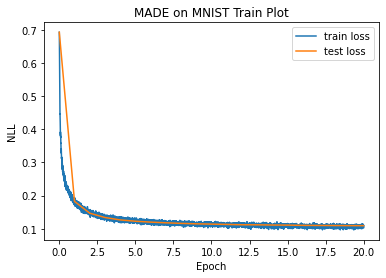

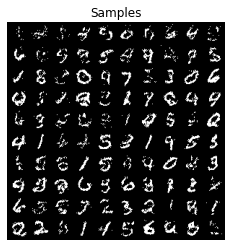

In [15]:
data_dir = get_data_dir()
train_data, test_data = load_pickled_data(join(data_dir, 'mnist.pkl'))
train_losses, test_losses, samples = train_MADE(train_data, test_data)
samples = samples.astype('float32') * 255
print(f'Final Test Loss: {test_losses[-1]:.4f}')
save_training_plot(train_losses, test_losses, f'MADE on MNIST Train Plot')
show_samples(samples)

## PixelCNN

Network design:
* A $7 \times 7$ masked type A convolution
* $5$ $7 \times 7$ masked type B convolutions
* $2$ $1 \times 1$ masked type B convolutions
* Appropriate ReLU nonlinearities in-between
* 64 convolutional filter

Hyperperamaters:
* Batch size 128
* Learning rate $10^{-3}$
* 10 epochs
* Adam Optimizer (this applies to all PixelCNN models trained in future parts)

Your model should output logits, after which you could apply a sigmoid over 1 logit, or a softmax over two logits (either is fine). It may also help to scale your input to $[-1, 1]$ before running it through the network.


In [16]:
class MaskConv2d(nn.Conv2d):
  def __init__(self, mask_type, *args, conditional_size=None, 
               color_conditioning=False, **kwargs):
    assert mask_type == 'A' or mask_type == 'B'
    super().__init__(*args, **kwargs)
    self.conditional_size = conditional_size
    self.color_conditioning = color_conditioning
    self.register_buffer('mask', torch.zeros_like(self.weight))
    self.create_mask(mask_type)
    if self.conditional_size:
      if len(self.conditional_size) == 1:
        self.cond_op = nn.Linear(conditional_size[0], self.out_channels)
      else:
        self.cond_op = nn.Conv2d(conditional_size[0], self.out_channels,
                                 kernel_size=3, padding=1)

  def forward(self, input, cond=None):
    batch_size = input.shape[0]
    out = F.conv2d(input, self.weight * self.mask, self.bias, self.stride,
                   self.padding, self.dilation, self.groups)
    if self.conditional_size:
      if len(self.conditional_size) == 1:
        # Broadcast across height and width of image and add as conditional bias
        out = out + self.cond_op(cond).view(batch_size, -1, 1, 1)
      else:
        out = out + self.cond_op(cond)
    return out

  def create_mask(self, mask_type):
    k = self.kernel_size[0]
    self.mask[:, :, :k // 2] = 1
    self.mask[:, :, k // 2, :k // 2] = 1
    if self.color_conditioning:
      assert self.in_channels % 3 == 0 and self.out_channels % 3 == 0
      one_third_in, one_third_out = self.in_channels // 3, self.out_channels // 3
      if mask_type == 'B':
        self.mask[:one_third_out, :one_third_in, k // 2, k // 2] = 1
        self.mask[one_third_out:2*one_third_out, :2*one_third_in, k // 2, k // 2] = 1
        self.mask[2*one_third_out:, :, k // 2, k // 2] = 1
      else:
        self.mask[one_third_out:2*one_third_out, :one_third_in, k // 2, k // 2] = 1
        self.mask[2*one_third_out:, :2*one_third_in, k // 2, k // 2] = 1
    else:
      if mask_type == 'B':
        self.mask[:, :, k // 2, k // 2] = 1

In [17]:
class ResBlock(nn.Module):
  def __init__(self, in_channels, **kwargs):
    super().__init__()
    self.block = nn.ModuleList([
        nn.ReLU(),
        MaskConv2d('B', in_channels, in_channels // 2, 1, **kwargs),
        nn.ReLU(),
        MaskConv2d('B', in_channels // 2, in_channels // 2, 7, padding=3, **kwargs),
        nn.ReLU(),
        MaskConv2d('B', in_channels // 2, in_channels, 1, **kwargs)
    ])

  def forward(self, x, cond=None):
    out = x
    for layer in self.block:
      if isinstance(layer, MaskConv2d):
        out = layer(out, cond=cond)
      else:
        out = layer(out)
    return out + x

In [18]:
class LayerNorm(nn.LayerNorm):
  def __init__(self, color_conditioning, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.color_conditioning = color_conditioning

  def forward(self, x):
    x = x.permute(0, 2, 3, 1).contiguous()
    x_shape = x.shape
    if self.color_conditioning:
      x = x.contiguous().view(*(x_shape[:-1] + (3, -1)))
    x = super().forward(x)
    if self.color_conditioning:
      x = x.view(*x_shape)
    return x.permute(0, 3, 1, 2).contiguous()

In [19]:
class PixelCNN(nn.Module):
  def __init__(self, input_shape, n_colors, n_filters=64,
               kernel_size=7, n_layers=5, 
               conditional_size=None, use_resblock=False,
               color_conditioning=False):
    super().__init__()
    assert n_layers >= 2
    n_channels = input_shape[0]

    kwargs = dict(conditional_size=conditional_size, 
                  color_conditioning=color_conditioning)
    if use_resblock:
      block_init = lambda: ResBlock(n_filters, **kwargs)
    else:    
      block_init = lambda: MaskConv2d('B', n_filters, n_filters, 
                                      kernel_size=kernel_size,
                                      padding=kernel_size // 2, **kwargs)
    
    model = nn.ModuleList([MaskConv2d('A', n_channels, n_filters, 
                                      kernel_size=kernel_size,
                                      padding=kernel_size // 2, **kwargs)])
    for _ in range(n_layers):
      if color_conditioning:
        model.append(LayerNorm(color_conditioning, n_filters // 3))
      else:
        model.append(LayerNorm(color_conditioning, n_filters))
      model.extend([nn.ReLU(), block_init()])
    model.extend([nn.ReLU(), MaskConv2d('B', n_filters, n_filters, 1, **kwargs)])
    model.extend([nn.ReLU(), MaskConv2d('B', n_filters, n_colors * n_channels, 1, **kwargs)])

    if conditional_size:
      if len(conditional_size) == 1:
        self.cond_op = lambda x: x # No preprocessing conditional if one hot
      else:
        # For Grayscale PixelCNN (some preprocessing on the binary image)
        self.cond_op = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU()
        )

    self.net = model
    self.input_shape = input_shape
    self.n_colors = n_colors
    self.n_channels = n_channels
    self.color_conditioning = color_conditioning
    self.conditional_size = conditional_size

  def forward(self, x, cond=None):
    batch_size = x.shape[0]
    out = (x.float() / (self.n_colors - 1) - 0.5) / 0.5
    if self.conditional_size:
      cond = self.cond_op(cond)
    for layer in self.net:
      if isinstance(layer, MaskConv2d) or isinstance(layer, ResBlock):
        out = layer(out, cond=cond)
      else:
        out = layer(out)

    if self.color_conditioning:
      return out.view(batch_size, self.n_channels, self.n_colors, 
                      *self.input_shape[1:]).permute(0, 2, 1, 3, 4)
    else:
      return out.view(batch_size, self.n_colors, *self.input_shape)

  def loss(self, x, cond=None):
    return F.cross_entropy(self(x, cond=cond), x.long())

  def sample(self, n, cond=None):
    samples = torch.zeros(n, *self.input_shape).cuda()
    with torch.no_grad():
      for r in range(self.input_shape[1]):
        for c in range(self.input_shape[2]):
          for k in range(self.n_channels):
            logits = self(samples, cond=cond)[:, :, k, r, c]
            probs = F.softmax(logits, dim=1)
            samples[:, k, r, c] = torch.multinomial(probs, 1).squeeze(-1)
    return samples.permute(0, 2, 3, 1).cpu().numpy()

In [20]:
def train_PixelCNN(train_data, test_data):
    train_data = np.transpose(train_data, (0, 3, 1, 2))
    test_data = np.transpose(test_data, (0, 3, 1, 2))

    H, W = (28, 28)
    model = PixelCNN((1, H, W), 2, n_layers=5).cuda()

    train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=128)
    train_losses, test_losses = train_epochs(model, train_loader, test_loader, dict(epochs=10, lr=1e-3))
    samples = model.sample(100)
    return train_losses, test_losses, samples

Final Test Loss: 0.0753


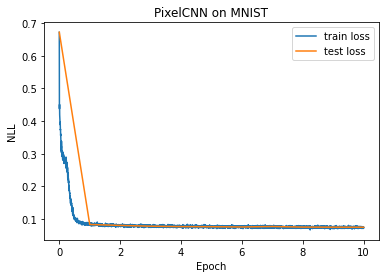

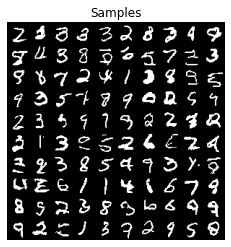

In [21]:
data_dir = get_data_dir()
train_data, test_data = load_pickled_data(join(data_dir, 'mnist.pkl'))
train_losses, test_losses, samples = train_PixelCNN(train_data, test_data)
samples = samples.astype('float32') * 255
print(f'Final Test Loss: {test_losses[-1]:.4f}')
save_training_plot(train_losses, test_losses, f'PixelCNN on MNIST')
show_samples(samples)